In [2]:
!pip install transformers
!pip install datasets

In [3]:
!pip install transformers
!pip install datasets
!pip install huggingface hub
!pip install pyarrow

In [4]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
DATA_PATH = r"C:\Users\Jash Progs\Dark patterns\dataset.tsv"

In [6]:
pandas_df = pd.read_csv(DATA_PATH,sep='\t')
pandas_df.head()

,page_id,text,label,Pattern Category
0,1012,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency
1,158,Pillowcases & Shams,0,Not Dark Pattern
2,108,Write a review,0,Not Dark Pattern
3,1425,"To start your return, simply click on the foll...",0,Not Dark Pattern
4,1658,newsletter signup (privacy policy),0,Not Dark Pattern


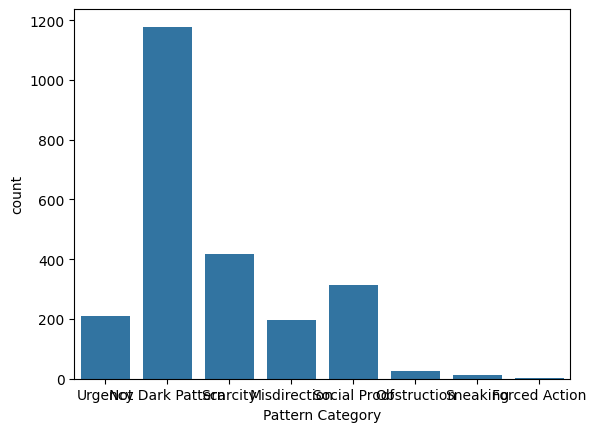

In [7]:
import seaborn as sns
# Assuming df is your DataFrame
sns.countplot(x='Pattern Category', data=pandas_df)
plt.show()


In [8]:
pandas_df['text_cleaned'] = pandas_df['text'].str.replace('@[A-Za_z0-9]+\s?','',regex=True)
pandas_df.head()

,page_id,text,label,Pattern Category,text_cleaned
0,1012,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency,FLASH SALE | LIMITED TIME ONLY Shop Now
1,158,Pillowcases & Shams,0,Not Dark Pattern,Pillowcases & Shams
2,108,Write a review,0,Not Dark Pattern,Write a review
3,1425,"To start your return, simply click on the foll...",0,Not Dark Pattern,"To start your return, simply click on the foll..."
4,1658,newsletter signup (privacy policy),0,Not Dark Pattern,newsletter signup (privacy policy)


In [9]:
from datasets import Dataset

ds = Dataset.from_pandas(pandas_df)
ds

Dataset({
    features: ['page_id', 'text', 'label', 'Pattern Category', 'text_cleaned'],
    num_rows: 2356
})

In [11]:

train_test_valid = ds.train_test_split()

test_valid = train_test_valid['test'].train_test_split()

train_test_valid_dataset = DatasetDict({
    'train' : train_test_valid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

dataset = train_test_valid_dataset.remove_columns(['page_id'])
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Pattern Category', 'text_cleaned'],
        num_rows: 1767
    })
    test: Dataset({
        features: ['text', 'label', 'Pattern Category', 'text_cleaned'],
        num_rows: 148
    })
    valid: Dataset({
        features: ['text', 'label', 'Pattern Category', 'text_cleaned'],
        num_rows: 441
    })
})

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [13]:
text = 'checking tokenizer'
output = tokenizer(text)
output

{'input_ids': [101, 9444, 22559, 17260, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [14]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['text_cleaned'],padding='max_length', truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/1767 [00:00<?, ? examples/s]

Map:   0%|          | 0/148 [00:00<?, ? examples/s]

Map:   0%|          | 0/441 [00:00<?, ? examples/s]

In [15]:
train_dataset

Dataset({
    features: ['text', 'label', 'Pattern Category', 'text_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1767
})

In [16]:
train_set = train_dataset.remove_columns(['text','text_cleaned']).with_format('tensorflow')

tf_eval_dataset = eval_dataset.remove_columns(['text','text_cleaned']).with_format('tensorflow')

tf_test_dataset = test_dataset.remove_columns(['text','text_cleaned']).with_format('tensorflow')

In [ ]:
import numpy as np

# For train_set
print("Train features shape:", {k: v.shape for k, v in train_features.items()})
print("Train labels shape:", train_set['label'].shape)

# For evaluation set
print("Evaluation features shape:", {k: v.shape for k, v in eval_features.items()})
print("Evaluation labels shape:", tf_eval_dataset['label'].shape)

# For test set
print("Test features shape:", {k: v.shape for k, v in test_features.items()})
print("Test labels shape:", tf_test_dataset['label'].shape)


In [18]:
train_features = {x: train_set[x] for x in tokenizer.model_input_names}
train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['label']))
train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(8)

eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset['label']))
val_set_for_final_model = val_set_for_final_model.batch(8)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset['label']))
test_set_for_final_model = test_set_for_final_model.batch(8)

In [22]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased",num_labels= 3)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
history = model.fit(train_set_for_final_model, validation_data = val_set_for_final_model, epochs=3)

Epoch 1/3
221/221 [==============================] - 3692s 17s/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.1312 - val_sparse_categorical_accuracy: 0.9705
Epoch 2/3
221/221 [==============================] - 15681s 71s/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.0811 - val_sparse_categorical_accuracy: 0.9728
Epoch 3/3
221/221 [==============================] - 4873s 22s/step - loss: 0.0150 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.0986 - val_sparse_categorical_accuracy: 0.9728


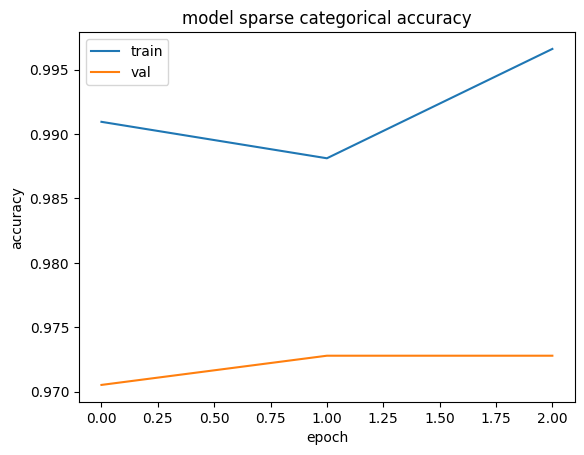

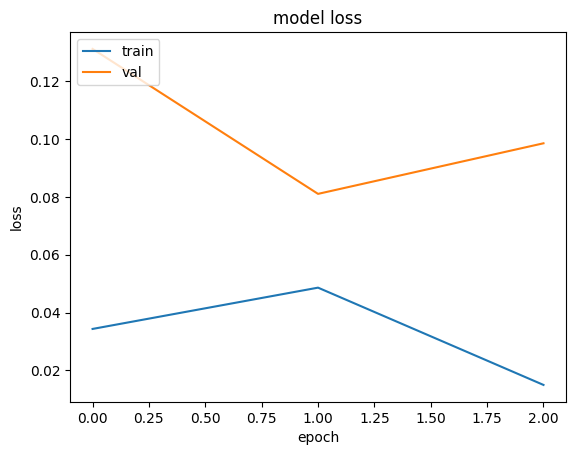

In [25]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [26]:
test_loss, test_acc = model.evaluate(test_set_for_final_model,verbose=2)
print('\nTest accuracy:',test_acc)

19/19 - 126s - loss: 0.1296 - sparse_categorical_accuracy: 0.9662 - 126s/epoch - 7s/step

Test accuracy: 0.9662162065505981


In [28]:
predict_score_and_class_dict = {
    0: 'Not a dark pattern',
    1: 'Dark pattern'
}

preds = model(tokenizer(["FLASH SALE,  hurry up 50% discount on every products", "Check us out" ], return_tensors="tf", padding=True,truncation=True))['logits']

print(preds)

class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
    print(predict_score_and_class_dict[pred])

tf.Tensor(
[[-2.6404514  6.2106266 -3.121224 ]
 [ 4.0929227 -2.1443617 -4.6120973]], shape=(2, 3), dtype=float32)
Dark pattern
Not a dark pattern
